In [27]:
# You might need to restart the runtime after running this code. You'll only
# have to do this once per runtime. Once you restart, you do not need to run this again
!pip install librosa
!pip install SoundFile
!pip install resampy

In [28]:
import numpy as np
print(np.__version__)

1.26.4


In [29]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# # Download data files
# downloaded = drive.CreateFile({'id':"1TjujGTMC98a4d0smt0D8Ff3ohDOtJzEk"})
# downloaded.GetContentFile('Colab_Data.zip')

# # Extract files to temporary location in Google Drive
# with zipfile.ZipFile('Colab_Data.zip', 'r') as zip_file:
#     zip_file.extractall()

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import librosa
print(librosa.__version__)
import glob
import os
import pandas as pd
from xml.dom import minidom
from scipy import signal
import librosa.display
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import random
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.patches as patches
import IPython.display as ipd
from IPython.display import Audio
import pickle

0.10.2.post1


In [36]:
# Paths
annotations_path = '/content/drive/MyDrive/DL4E_Project/Annotations/'
original_audio_path = '/content/drive/MyDrive/DL4E_Project/Audio/'
downsampled_audio_path = './Colab_Data/Downsampled_Audio/'


species_folder = './'
file_type = '.svl'
audio_extension = '.mp3'
training_files = '/content/drive/MyDrive/DL4E_Project/train_multi.csv'


# Data hyper-parameters
# -----------------------------
downsample_rate = 20000
segment_duration = 2


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024
hop_length = 256
n_mels = 64

# To decide on these, you might want to work on a single audio file
# to figure out what are suitable values so that you can see the different events
# you might want to work in conjunction with SonicVisualiser + loaded annotations
# for a particular file

#test_audio = '/content/Colab_Data/Audio/20241111_195700_AIMS.WAV'

#test_audio ='/content/Colab_Data/Audio/20241113_024800_CC.WAV'

test_audio ='/content/drive/MyDrive/DL4E_Project/Audio/audio_1.mp3'

test_amp, test_sr = librosa.load(test_audio, sr=None)
print(f'test_sr == {test_sr}')

#partitioned_test_audio = test_amp[int(236.6468*test_sr):int(242.965*test_sr)]

partitioned_test_audio = test_amp[:int(6*test_sr)]

Audio(partitioned_test_audio, rate= test_sr)

<ipython-input-36-bd54dbe94ccb>:36: UserWarning: PySoundFile failed. Trying audioread instead.
  test_amp, test_sr = librosa.load(test_audio, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


test_sr == 48000


[Text(0.5, 1.0, 'Mel-frequency Spectogram')]

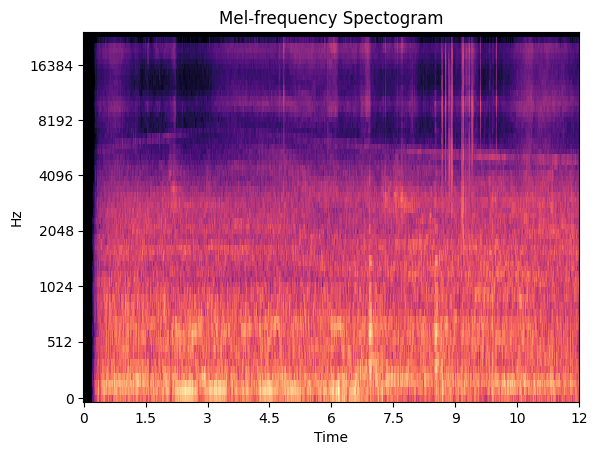

In [7]:

s = librosa.feature.melspectrogram(y=partitioned_test_audio, sr = test_sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
s_db = librosa.power_to_db(s, ref=np.max)

fig, ax = plt.subplots()
img = librosa.display.specshow(s_db, x_axis='time', y_axis='mel', sr=test_sr, ax=ax)
ax.set(title='Mel-frequency Spectogram')



In [8]:
s_db.shape

(64, 1126)

In [14]:
# You most likely will not modify this
def get_annotation_information(file_name, audio_amps, sample_rate):

  # Process the .svl xml file
  xmldoc = minidom.parse(annotations_path+file_name+'.svl')
  itemlist = xmldoc.getElementsByTagName('point')
  idlist = xmldoc.getElementsByTagName('model')

  start_time = []
  end_time = []
  labels = []
  audio_file_name = ''

  print ('get annotation information')
  print(f'len(itemlist) ={len(itemlist)}')

  if (len(itemlist) > 0):

      print(file_name)

      # Iterate over each annotation in the .svl file (annotatation file)
      for s in itemlist:

          # Get the starting seconds from the annotation file. Must be an integer
          # so that the correct frame from the waveform can be extracted
          start_seconds = float(s.attributes['frame'].value)/sample_rate
          print('start_seconds', start_seconds)

          # Get the label from the annotation file
          label = str(s.attributes['label'].value)

          # If a file has a blank label then skip this annotation
          # to avoid mislabelling data
          if label == '':
              break

          # Get the duration from the annotation file
          annotation_duration_seconds = float(s.attributes['duration'].value)/sample_rate
          start_time.append(start_seconds)
          end_time.append(start_seconds+annotation_duration_seconds)
          labels.append(label)

  df_annotations = pd.DataFrame({'Start': start_time, 'End':end_time ,'Label': labels})
  return df_annotations, file_name+'.wav'

In [16]:
#df, audio_file_name = get_annotation_information('20241111_195700_AIMS', test_amp,test_sr)#
df, audio_file_name = get_annotation_information('audio_1', test_amp,test_sr)


get annotation information
len(itemlist) =89
audio_1
start_seconds 0.984
start_seconds 1.832
start_seconds 13.064
start_seconds 13.496
start_seconds 14.784
start_seconds 15.4
start_seconds 17.136
start_seconds 20.44
start_seconds 21.408
start_seconds 22.52
start_seconds 23.504
start_seconds 24.656
start_seconds 25.36
start_seconds 26.744
start_seconds 30.072
start_seconds 31.776
start_seconds 34.392
start_seconds 35.928
start_seconds 38.712
start_seconds 39.608
start_seconds 40.712
start_seconds 43.312
start_seconds 51.8
start_seconds 52.88
start_seconds 53.192
start_seconds 60.384
start_seconds 61.272
start_seconds 61.856
start_seconds 62.256
start_seconds 64.464
start_seconds 70.72
start_seconds 84.424
start_seconds 85.464
start_seconds 88.52
start_seconds 93.16
start_seconds 109.72
start_seconds 112.52
start_seconds 112.52
start_seconds 119.016
start_seconds 119.72
start_seconds 120.88
start_seconds 121.32
start_seconds 130.024
start_seconds 130.76
start_seconds 132.96
start_seconds

In [17]:
df.loc[0]

,0
Start,0.984
End,1.192
Label,b


In [18]:
df

,Start,End,Label
0,0.984,1.192,b
1,1.832,3.288,a
2,13.064,13.360,b
3,13.496,14.152,a
4,14.784,15.008,b
...,...,...,...
84,307.464,307.768,b
85,312.464,312.912,b
86,327.280,328.992,n
87,334.112,335.952,n


In [19]:
def read_audio_file(file_name):
    amps, sr = librosa.load(file_name, sr=None)

    return amps, sr

In [20]:
# You most likely will not modify this
def getXY(audio_amplitudes, start_sec, annotation_duration_seconds,
          labels, sample_rate, verbose):

    if verbose == True:
        print ('start_sec', start_sec)
        print ('annotation_duration_seconds', annotation_duration_seconds)
        print ('segment_duration ', segment_duration )

    X_segments = []
    Y_labels = []

    # Calculate how many segments can be extracted based on the duration of
    # the annotated duration. If the annotated duration is too short then
    # simply extract one segment. If the annotated duration is long enough
    # then multiple segments can be extracted.
    if annotation_duration_seconds-segment_duration < 0:
        segments_to_extract = 1
    else:
        segments_to_extract = annotation_duration_seconds - segment_duration + 1

    if verbose:
        print ("segments_to_extract", segments_to_extract)

    for i in range (0, segments_to_extract):
        if verbose:
            print ('Semgnet {} of {}'.format(i, segments_to_extract-1))
            print ('*******************')

        # Set the correct location to start with.
        # The correct start is with respect to the location in time
        # in the audio file start+i*sample_rate
        start_data_observation = start_sec*sample_rate+i*(sample_rate)

        # The end location is based off the start
        end_data_observation = start_data_observation + (sample_rate*segment_duration)

        # This case occurs when something is annotated towards the end of a file
        # and can result in a segment which is too short.
        if end_data_observation > len(audio_amplitudes):
            continue

        # Extract the segment of audio
        X_audio = audio_amplitudes[start_data_observation:end_data_observation]

        if verbose == True:
            print ('start frame', start_data_observation)
            print ('end frame', end_data_observation)

        # Extend the segments and labels
        X_segments.append(X_audio)
        Y_labels.append(labels)

    return X_segments, Y_labels

In [21]:
def process_overlaps(df, mlb):
    # Get distinct time points
    time_points = sorted(set(df['Start']).union(df['End']))

    # Create time intervals
    time_intervals = [(time_points[i], time_points[i+1] ) for i in range(len(time_points)-1)]

    # Generate new dataframe with 6 columns: Start, End, a, b, n, w
    # Assign labels to each interval
    interval_data = []
    for start, end in time_intervals:
        # Get labels active in the current interval
        active_labels = df[(df['Start'] <= start) & (df['End'] > start)]['Label'].tolist()
        interval_data.append({'Start': start, 'End': end, 'labels': active_labels})

    # Apply MultiLabelBinarizer
    binary_labels = mlb.fit_transform([item['labels'] for item in interval_data])

    # Step 5: Create the final DataFrame
    multi_label_df = pd.DataFrame(binary_labels, columns=mlb.classes_)
    multi_label_df['Start'] = [item['Start'] for item in interval_data]
    multi_label_df['End'] = [item['End'] for item in interval_data]

    # Reorder columns
    multi_label_df = multi_label_df[['Start', 'End'] + mlb.classes_.tolist()]

    # Filter out rows where all label columns are zero
    label_columns = mlb.classes_.tolist()
    multi_label_df = multi_label_df[(multi_label_df[label_columns].sum(axis=1) > 0)]

    # Reset the index
    multi_label_df = multi_label_df.reset_index(drop=True)

    return multi_label_df

In [22]:
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])
multi_label_df = process_overlaps(df, mlb)
multi_label_df

,Start,End,a,b,n,w
0,0.984,1.192,0,1,0,0
1,1.832,3.288,1,0,0,0
2,13.064,13.360,0,1,0,0
3,13.496,14.152,1,0,0,0
4,14.784,15.008,0,1,0,0
...,...,...,...,...,...,...
92,307.464,307.768,0,1,0,0
93,312.464,312.912,0,1,0,0
94,327.280,328.992,0,0,1,0
95,334.112,335.952,0,0,1,0


In [37]:
def create_dataset(verbose, mlb):

        # Initialise lists to store the X and Y values
        X_calls = []
        Y_calls = []

        if verbose == True:
            print ('Annotations path:',annotations_path+"*.svl")
            print ('Audio path',original_audio_path+"*.mp3")

        # Read all names of the training files
        training_file_names = pd.read_csv(training_files, header=None)

        # Iterate over each annotation file
        for training_file in training_file_names.values:

            filename = training_file[0]

            print ('Processing file:',filename)

            print('Looking for this file: ', original_audio_path+filename+audio_extension)
            print('From these files here: ', original_audio_path+"*"+audio_extension)

            # Check if the .wav file exists before processing
            if original_audio_path+filename+audio_extension  in glob.glob(original_audio_path+"*"+audio_extension):
                print(f'Found file = {original_audio_path+filename+audio_extension }')

                print(f'filename= {filename}')

                # Read audio file
                signal, original_sample_rate = read_audio_file(original_audio_path+filename+audio_extension)

                #resample signal

                signal_downsampled = librosa.resample(y=signal, orig_sr=original_sample_rate, target_sr=downsample_rate)


                # Get the start/stop time of each annotated event
                df, audio_file_name = get_annotation_information(filename, signal_downsampled,
                                                                 original_sample_rate)

                # The dataframe above will have a number of annotated events
                # each with a unique label. (i.e. not multi-label)
                # You need to combine these events
                # that overlap in time so that events with two or more labels
                # appear as a single row with the corresponding label
                # for example [1,1,0,0] means that event a and b happened.
                # Store the result in a variable called mult_label_df
                # as this will be a dataframe where you'll create a muli-label
                # dataset! Do not modify the name of this dataframe as it will
                # be used below, and you will be assessed on this.
                multi_label_df = process_overlaps(df, mlb)

                # You need to print this dataframe as you will be assessed on this
                print(f'multi_label_df\n{multi_label_df}')

                # At this point you would have a processed dataframe.
                # each row would be an acoustic event with one or more targets.
                # There are 4 possible targets
                # a, b, n and w
                # a = anthropohony (including human speech)
                # b = biophony
                # n = absence of sound event
                # w = wind
                # So example rows could be:
                # Start = 10, End = 12, a = 1, b= 0, n = 0, w= 1
                # Start = 20, End = 22, a = 0, b= 1, n = 0, w= 1
                # Start = 30, End = 32, a = 0, b= 1, n = 0, w= 0

                print('Reading annotations...')
                for index, row in multi_label_df.iterrows():

                    start_seconds = int(round(row['Start']))
                    end_seconds = int(round(row['End']))

                    # You might want to handle special cases where the current
                    # start window overlaps into another labelled event
                    # this happens when start + duration overlaps with the next event
                    # in the dataframe

                    # Note there is another special case, where the current event
                    # overlaps with the next, but the next event doesn't introduce
                    # new sounds, this you can include the next event

                    # Combine all the labels for this row
                    labels = [row['a'], row['b'], row['n'], row['w']]
                    annotation_duration_seconds = end_seconds - start_seconds

                    # Extract augmented audio segments and corresponding binary labels
                    X_data, y_data = getXY(signal_downsampled, start_seconds,
                                                annotation_duration_seconds,
                                           labels, downsample_rate, verbose)

                    # Append the segments and labels
                    X_calls.extend(X_data)
                    Y_calls.extend(y_data)

        # Convert to numpy arrays
        X_calls, Y_calls = np.asarray(X_calls), np.asarray(Y_calls)

        return X_calls, Y_calls

In [38]:
# Initialize MultiLabelBinarizer for binary encoding
mlb = MultiLabelBinarizer(classes=['a', 'b', 'n', 'w'])

X, Y = create_dataset(False, mlb)

Processing file: audio_1
Looking for this file:  /content/drive/MyDrive/DL4E_Project/Audio/audio_1.mp3
From these files here:  /content/drive/MyDrive/DL4E_Project/Audio/*.mp3
Found file = /content/drive/MyDrive/DL4E_Project/Audio/audio_1.mp3
filename= audio_1


<ipython-input-19-8332ddf438c7>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  amps, sr = librosa.load(file_name, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


get annotation information
len(itemlist) =89
audio_1
start_seconds 0.984
start_seconds 1.832
start_seconds 13.064
start_seconds 13.496
start_seconds 14.784
start_seconds 15.4
start_seconds 17.136
start_seconds 20.44
start_seconds 21.408
start_seconds 22.52
start_seconds 23.504
start_seconds 24.656
start_seconds 25.36
start_seconds 26.744
start_seconds 30.072
start_seconds 31.776
start_seconds 34.392
start_seconds 35.928
start_seconds 38.712
start_seconds 39.608
start_seconds 40.712
start_seconds 43.312
start_seconds 51.8
start_seconds 52.88
start_seconds 53.192
start_seconds 60.384
start_seconds 61.272
start_seconds 61.856
start_seconds 62.256
start_seconds 64.464
start_seconds 70.72
start_seconds 84.424
start_seconds 85.464
start_seconds 88.52
start_seconds 93.16
start_seconds 109.72
start_seconds 112.52
start_seconds 112.52
start_seconds 119.016
start_seconds 119.72
start_seconds 120.88
start_seconds 121.32
start_seconds 130.024
start_seconds 130.76
start_seconds 132.96
start_seconds

<ipython-input-19-8332ddf438c7>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  amps, sr = librosa.load(file_name, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


get annotation information
len(itemlist) =129
audio_2
start_seconds 1.536
start_seconds 2.48
start_seconds 2.912
start_seconds 3.504
start_seconds 4.592
start_seconds 5.36
start_seconds 7.408
start_seconds 8.144
start_seconds 9.344
start_seconds 10.912
start_seconds 12.48
start_seconds 12.64
start_seconds 14.912
start_seconds 15.84
start_seconds 17.968
start_seconds 21.68
start_seconds 25.696
start_seconds 28.688
start_seconds 30.208
start_seconds 30.656
start_seconds 30.944
start_seconds 34.64
start_seconds 38.288
start_seconds 41.952
start_seconds 42.752
start_seconds 43.44
start_seconds 44.128
start_seconds 44.464
start_seconds 45.312
start_seconds 46.784
start_seconds 47.824
start_seconds 48.176
start_seconds 48.592
start_seconds 49.904
start_seconds 50.416
start_seconds 51.504
start_seconds 52.832
start_seconds 52.96
start_seconds 54.384
start_seconds 55.552
start_seconds 55.952
start_seconds 56.272
start_seconds 57.552
start_seconds 58.176
start_seconds 60.944
start_seconds 61.52

<ipython-input-19-8332ddf438c7>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  amps, sr = librosa.load(file_name, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


get annotation information
len(itemlist) =290
audio_3
start_seconds 0.0
multi_label_df
Empty DataFrame
Columns: [Start, End, a, b, n, w]
Index: []
Reading annotations...
Processing file: audio_4
Looking for this file:  /content/drive/MyDrive/DL4E_Project/Audio/audio_4.mp3
From these files here:  /content/drive/MyDrive/DL4E_Project/Audio/*.mp3
Found file = /content/drive/MyDrive/DL4E_Project/Audio/audio_4.mp3
filename= audio_4


<ipython-input-19-8332ddf438c7>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  amps, sr = librosa.load(file_name, sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


get annotation information
len(itemlist) =174
audio_4
start_seconds 0.0
multi_label_df
Empty DataFrame
Columns: [Start, End, a, b, n, w]
Index: []
Reading annotations...


In [39]:
# print the shape of X and Y
print(f'shape of X = {X.shape}')
print(f'shape of Y = {Y.shape}')

shape of X = (254, 40000)
shape of Y = (254, 4)


In [41]:
# Save to pickle file
# Save X and Y once this preprocessing step is done as this is time consuming!
import pickle

with open('/content/drive/MyDrive/preprocessed_data_1.pkl', 'wb') as file:
    pickle.dump((X, Y), file)
print("Data saved successfully!")

Data saved successfully!


In [43]:
# Load from pickle file to avoid running that pre-processing each time you want to run this script
with open('/content/drive/MyDrive/preprocessed_data_1.pkl', 'rb') as file:
    X_loaded, Y_loaded = pickle.load(file)

print("Data loaded successfully!")
print(f"X shape: {X_loaded.shape}, Y shape: {Y_loaded.shape}")

Data loaded successfully!
X shape: (254, 40000), Y shape: (254, 4)


In [44]:
X_loaded

array([[ 0.00267768,  0.00298556,  0.00342728, ..., -0.00377367,
        -0.00383156, -0.00371899],
       [-0.00388384, -0.00496149, -0.00621314, ...,  0.00464941,
         0.00759359,  0.00992103],
       [ 0.00040291,  0.00065717,  0.00038817, ...,  0.00127679,
         0.00138139,  0.00119004],
       ...,
       [ 0.0037051 ,  0.00223086, -0.00026871, ..., -0.0162345 ,
        -0.01349532, -0.01099118],
       [-0.00786364, -0.00481975, -0.00092984, ...,  0.00191401,
        -0.00073408, -0.010415  ],
       [-0.00786364, -0.00481975, -0.00092984, ...,  0.00191401,
        -0.00073408, -0.010415  ]], dtype=float32)

In [45]:
Y_loaded

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [46]:
# convert to numpy arrays
X_loaded = np.array(X_loaded)
Y_loaded = np.array(Y_loaded)

# Plot distribution of the different events. this includes events where there is more than one target!

In [47]:
# Find unique events combinations and their counts
unique_events, counts = np.unique(Y_loaded, axis=0, return_counts=True)

# Print the unique combinations and their frequencies
for row, count in zip(unique_events, counts):
    print(f"Combination: {row}, Count: {count}")

Combination: [0. 0. 0. 1.], Count: 43
Combination: [0. 0. 1. 0.], Count: 29
Combination: [0. 1. 0. 0.], Count: 135
Combination: [0. 1. 0. 1.], Count: 10
Combination: [1. 0. 0. 0.], Count: 32
Combination: [1. 1. 0. 0.], Count: 5


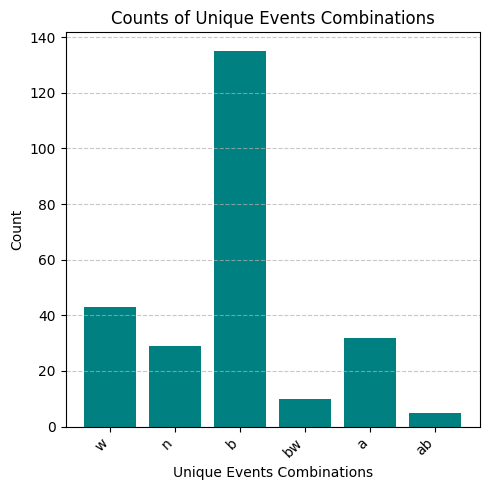

In [48]:
# Corresponding labels
labels_map = ['a', 'b', 'n', 'w']

# Convert binary rows to label strings
def row_to_labels(row):
    return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

# Generate labels for each unique row
formatted_labels = [row_to_labels(row) for row in unique_events]

# Plot the bar chart
plt.figure(figsize=(5, 5))
plt.bar(formatted_labels, counts, color='teal')

# Add labels and title
plt.xlabel('Unique Events Combinations')
plt.ylabel('Count')
plt.title('Counts of Unique Events Combinations')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Save plot
plt.savefig("/content/drive/MyDrive/events_distributions.pdf", format="pdf", dpi=3000)

# Show the plot
plt.tight_layout()
plt.show()

In [49]:
# Convert the audio segments into spectrograms
spectrograms = []

for x in X_loaded:
  S = librosa.feature.melspectrogram(y=x, sr=downsample_rate, n_fft=n_fft, hop_length=hop_length, n_mels= n_mels)
  S_db = librosa.power_to_db(S, ref= np.max)
  spectrograms.append(S_db)

# Convert to numpy array
spectrograms = np.array(spectrograms)

In [50]:
spectrograms.shape

(254, 64, 157)

In [51]:
spectrograms[0]

array([[-27.298935 , -23.344631 , -22.259102 , ..., -18.8751   ,
        -20.936512 , -21.376991 ],
       [-11.832002 ,  -7.8456984,  -9.687312 , ..., -12.791579 ,
         -9.459308 ,  -9.932496 ],
       [ -9.318477 ,  -8.727117 ,  -9.89437  , ..., -10.863194 ,
         -8.267209 , -11.332229 ],
       ...,
       [-59.77621  , -58.353268 , -58.456448 , ..., -45.69883  ,
        -45.4698   , -47.800037 ],
       [-59.149067 , -59.032528 , -59.455723 , ..., -42.628304 ,
        -42.1402   , -44.68433  ],
       [-59.54208  , -60.463726 , -61.526897 , ..., -45.663822 ,
        -45.617947 , -46.4336   ]], dtype=float32)

[Text(0.5, 1.0, 'Mel-frequency Spectogram')]

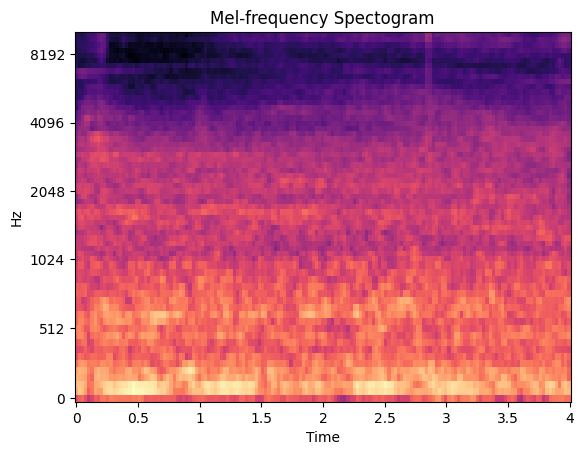

In [52]:
fig, ax = plt.subplots()
img = librosa.display.specshow(spectrograms[0], x_axis='time', y_axis='mel', sr=downsample_rate, ax=ax)
ax.set(title='Mel-frequency Spectogram')

In [53]:
# Save to pickle file
import pickle

with open('/content/drive/MyDrive/segments_spectrograms_1.pkl', 'wb') as file:
    pickle.dump((spectrograms, Y_loaded), file)
print("Data saved successfully!")

Data saved successfully!


In [54]:
# Load from pickle file to save time (next time you run the script)
import pickle
with open('/content/drive/MyDrive/segments_spectrograms_1.pkl', 'rb') as file:
    segments_spectrograms_loaded, targets_loaded = pickle.load(file)

print("Data loaded successfully!")

Data loaded successfully!


In [55]:
# print the shapes of the spectrograms and targets
print(f'segments_spectrograms_loaded shape == {segments_spectrograms_loaded.shape}\ntargets shape == {targets_loaded.shape}')

segments_spectrograms_loaded shape == (254, 64, 157)
targets shape == (254, 4)


In [56]:
# once you have spectrograms, you might want to delete  some old variables to save some RAM
# I'll only mention this hint once.
import gc

# Delete unnecessary variables
#del X_loaded, Y_loaded
#del X_augmented, Y_augmented
#del X_train, Y_train
#del spectrograms_augmented, targets_augmented
#del spectrograms, Y_loaded, X_loaded

# Explicitly run garbage collection
gc.collect()


3614

# Train and val splitting

In [57]:
from sklearn.model_selection import train_test_split
seed = 123

X_train, X_val, Y_train, Y_val = train_test_split(segments_spectrograms_loaded, targets_loaded,
            test_size=0.2, random_state=seed,
            shuffle=True)


In [58]:
# print shapes of training and validation data
print(f'X_train  shape === {X_train.shape}\nX_val shape === {X_val.shape}\nY_train === {Y_train.shape}\nY_val shape === {Y_val.shape}')

X_train  shape === (203, 64, 157)
X_val shape === (51, 64, 157)
Y_train === (203, 4)
Y_val shape === (51, 4)


# Perform data augmentation

In [59]:
def rolling_augmentation(spectrogram, label, no_of_augmentations):
  #print(f'shape of spectrogram == {spectrogram.shape}')
  spectrograms_augmented = []
  targets_augmented = []

  for i in range(no_of_augmentations):
    # Randomly shift the spectrogram by some random value
    augmented= np.roll(spectrogram,shift = random.randint(0,len(spectrogram)-1))
    #print(f'shape of augmented =={ augmented.shape}')
    spectrograms_augmented.append(augmented)
    targets_augmented.append(label)

  return spectrograms_augmented, targets_augmented

In [69]:
def augment_per_event(x_train,y_train):
    unique_events, counts = np.unique(y_train, axis=0, return_counts=True)

    final_spectrograms_augmented = []
    final_targets_augmented = []

    for unique_event, count in zip(unique_events, counts):
      if count < 220:
        no_to_augment = 220 - count
        matching_indices = np.where((y_train == unique_event).all(axis=1))[0]

        if no_to_augment < count:
          no_of_augmentations =1
          count = no_to_augment
        else:
          no_of_augmentations = int(no_to_augment/count)


        if no_of_augmentations > 0:
          for ind in matching_indices[:count]:
            spectrograms_augmented, targets_augmented = rolling_augmentation(x_train[ind], unique_event, no_of_augmentations)
            final_spectrograms_augmented.extend(spectrograms_augmented)
            final_targets_augmented.extend(targets_augmented)

    # Convert lists to numpy arrays
    final_spectrograms_augmented = np.asarray(final_spectrograms_augmented)
    final_targets_augmented = np.asarray(final_targets_augmented)

    #concatenate with the original dataset
    final_spectrograms_augmented = np.concatenate((x_train, final_spectrograms_augmented), axis=0)
    final_targets_augmented = np.concatenate((y_train, final_targets_augmented), axis=0)


    return final_spectrograms_augmented, final_targets_augmented




In [70]:
X_augmented, Y_augmented = augment_per_event(X_train, Y_train)

In [71]:
X_augmented.shape

(1278, 64, 157)

In [72]:
Y_augmented.shape

(1278, 4)

# View the amount of training/validation data and their distributions

In [73]:
def plotting_labels(labels, title):

  # Find unique events combinations and their counts
  unique_events, counts = np.unique(labels, axis=0, return_counts=True)

  # Print the unique combinations and their frequencies
  for row, count in zip(unique_events, counts):
      print(f"Combination: {row}, Count: {count}")

  # Corresponding labels
  labels_map = ['a', 'b', 'n', 'w']

  # Convert binary rows to label strings
  def row_to_labels(row):
      return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

  # Generate labels for each unique row
  formatted_labels = [row_to_labels(row) for row in unique_events]

  # Plot the bar chart
  plt.figure(figsize=(5, 5))
  plt.bar(formatted_labels, counts, color='teal')

  # Add labels and title
  plt.xlabel('Unique Events Combinations')
  plt.ylabel('Count')
  plt.title(f'{title} Labels Counts of Unique Events Combinations')
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Save plot
  plt.savefig(f"/content/drive/MyDrive/{title}_events_distributions_1.pdf", format="pdf", dpi=3000)

  # Show the plot
  plt.tight_layout()
  plt.show()

Combination: [0. 0. 0. 1.], Count: 210
Combination: [0. 0. 1. 0.], Count: 200
Combination: [0. 1. 0. 0.], Count: 216
Combination: [0. 1. 0. 1.], Count: 216
Combination: [1. 0. 0. 0.], Count: 216
Combination: [1. 1. 0. 0.], Count: 220


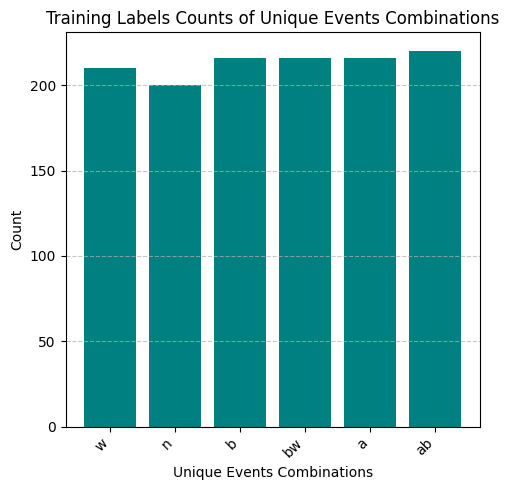

In [74]:
# Plot training labels
plotting_labels(Y_augmented, title='Training')

Combination: [0. 0. 0. 1.], Count: 13
Combination: [0. 0. 1. 0.], Count: 4
Combination: [0. 1. 0. 0.], Count: 27
Combination: [0. 1. 0. 1.], Count: 2
Combination: [1. 0. 0. 0.], Count: 5


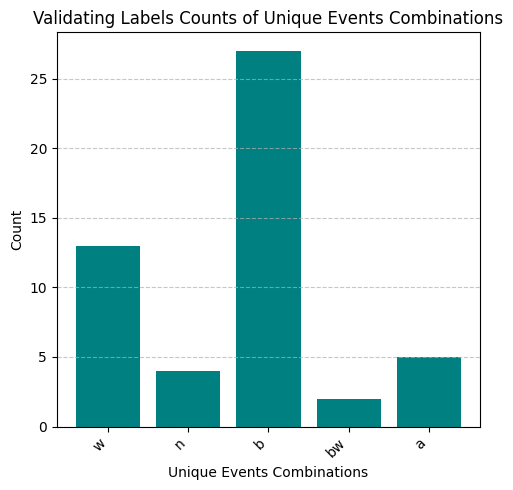

In [75]:
# Plot validation labels
plotting_labels(Y_val, title='Validating')

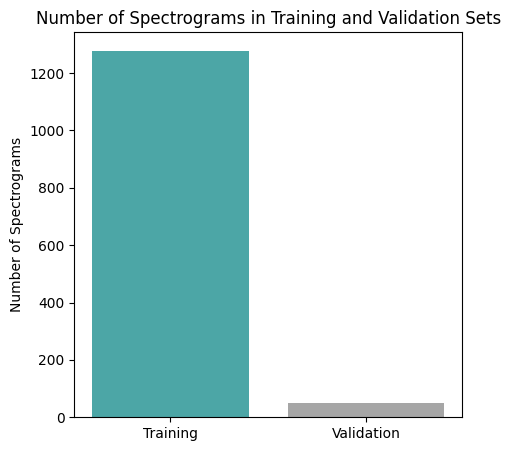

In [76]:
# Number of samples in training and validation datasets
num_train_samples = X_augmented.shape[0]
num_val_samples = X_val.shape[0]

# Plot a bar chart
plt.figure(figsize=(5, 5))
plt.bar(['Training', 'Validation'], [num_train_samples, num_val_samples], color=['teal', 'grey'], alpha=0.7)

# Add labels and title
plt.ylabel('Number of Spectrograms')
plt.title('Number of Spectrograms in Training and Validation Sets')

# Save plot
plt.savefig(f"/content/drive/MyDrive/spectrograms_training_val_distributions_1.pdf", format="pdf", dpi=3000)
plt.show()

# Display 5 spectrogram examples of each of the different types of targets

In [ ]:
# Display 5 spectrogram examples of each of the different types of targets
# in each case view the spectrogram and display the target. Note that some
# events are multi-label, so you need to show 5 examples for each different
# multi/single event

In [77]:
def plot_spectrograms(spectrograms, labels, sr, no_of_plots):
    # Find unique events combinations and their counts
    unique_events, _ = np.unique(labels, axis=0, return_counts=True)

    # Corresponding labels
    labels_map = ['a', 'b', 'n', 'w']

    # Convert binary rows to label strings
    def row_to_labels(row):
        return ''.join([labels_map[i] for i, val in enumerate(row.astype(int)) if val == 1])

    # Generate labels for each unique row
    formatted_labels = [row_to_labels(row) for row in unique_events]

    for id, target_row in enumerate(unique_events):
      # Find the indices of rows that match the target row
      matching_indices = np.where((labels == target_row).all(axis=1))[0]

      formatted_label = formatted_labels[id]

      # Create a single figure with 5 subplots in a single row
      fig, axes = plt.subplots(1, 5, figsize=(20, no_of_plots))

      for index, label_index in enumerate(matching_indices[:no_of_plots]):
          # Extract the spectrogram
          s_db = spectrograms[label_index]

          # Plot on the corresponding axis
          ax = axes[index]
          img = librosa.display.specshow(s_db, x_axis='time', y_axis='mel', sr=sr, ax=ax)
          ax.set_title(f'{index+1}: {formatted_label} :{target_row} Presence')
          fig.colorbar(img, ax=ax, format="%+2.0f dB")

      # Adjust layout
      plt.tight_layout()

      # Save plot
      #plt.savefig(f"/content/drive/MyDrive/unique_events_samples_spectrograms.pdf", format="pdf", dpi=3000)

      plt.show()


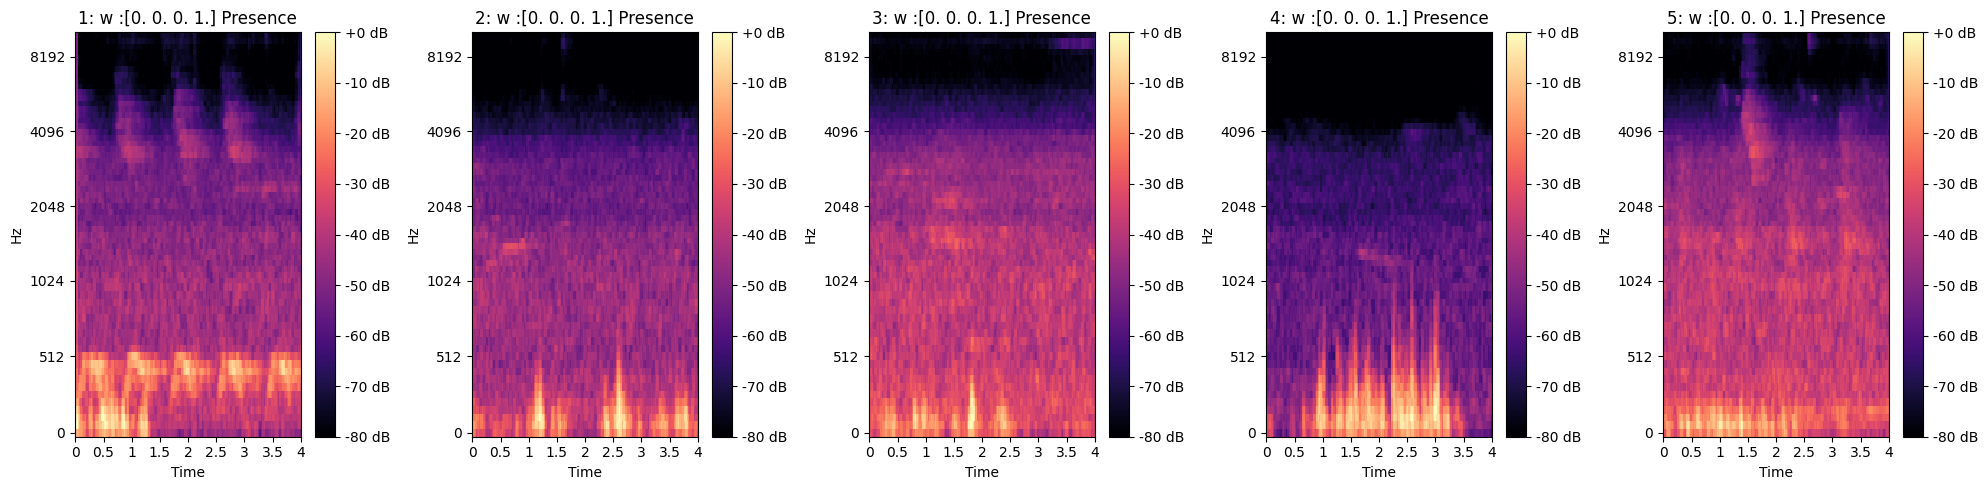

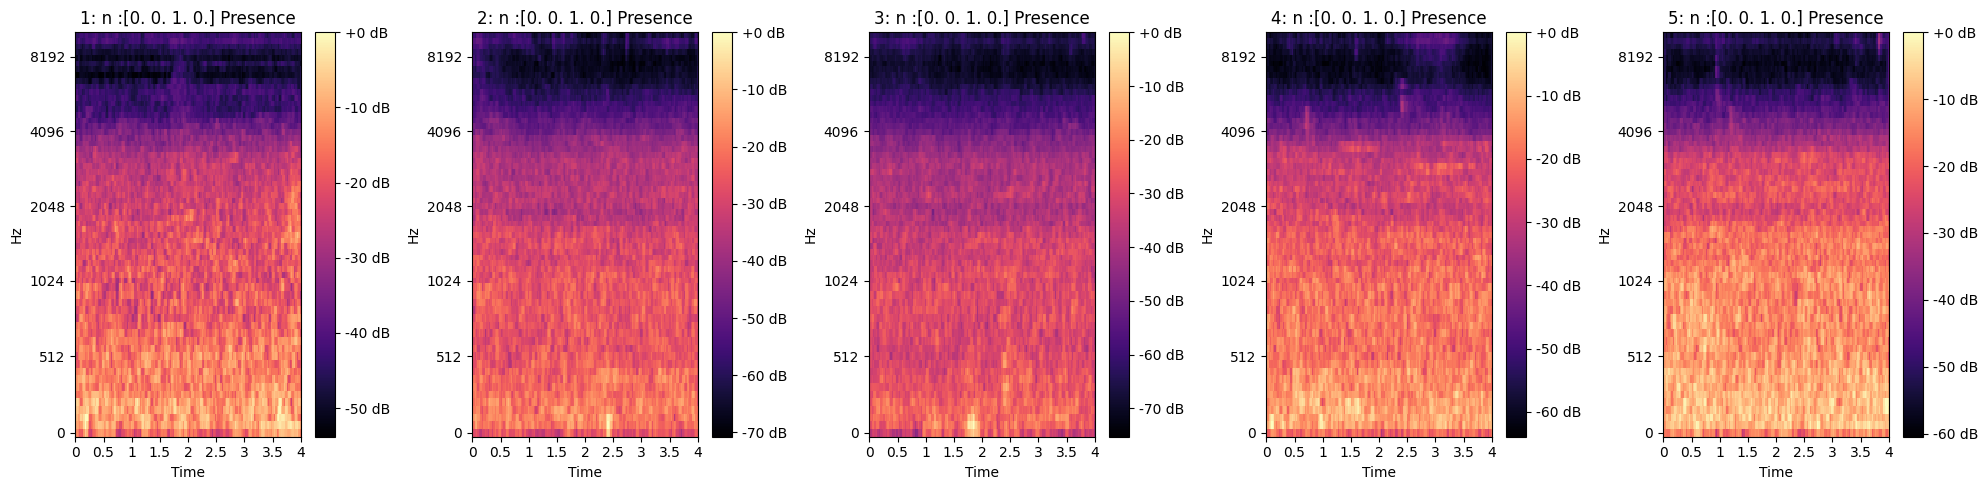

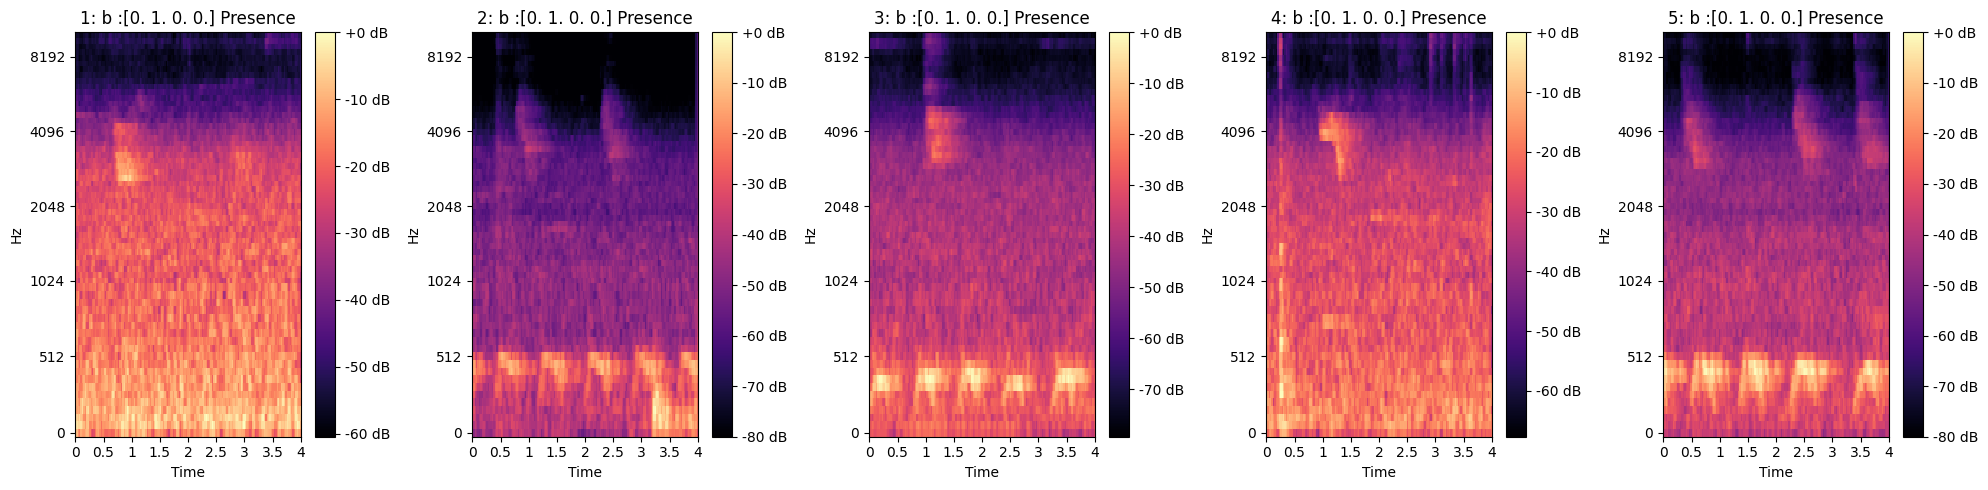

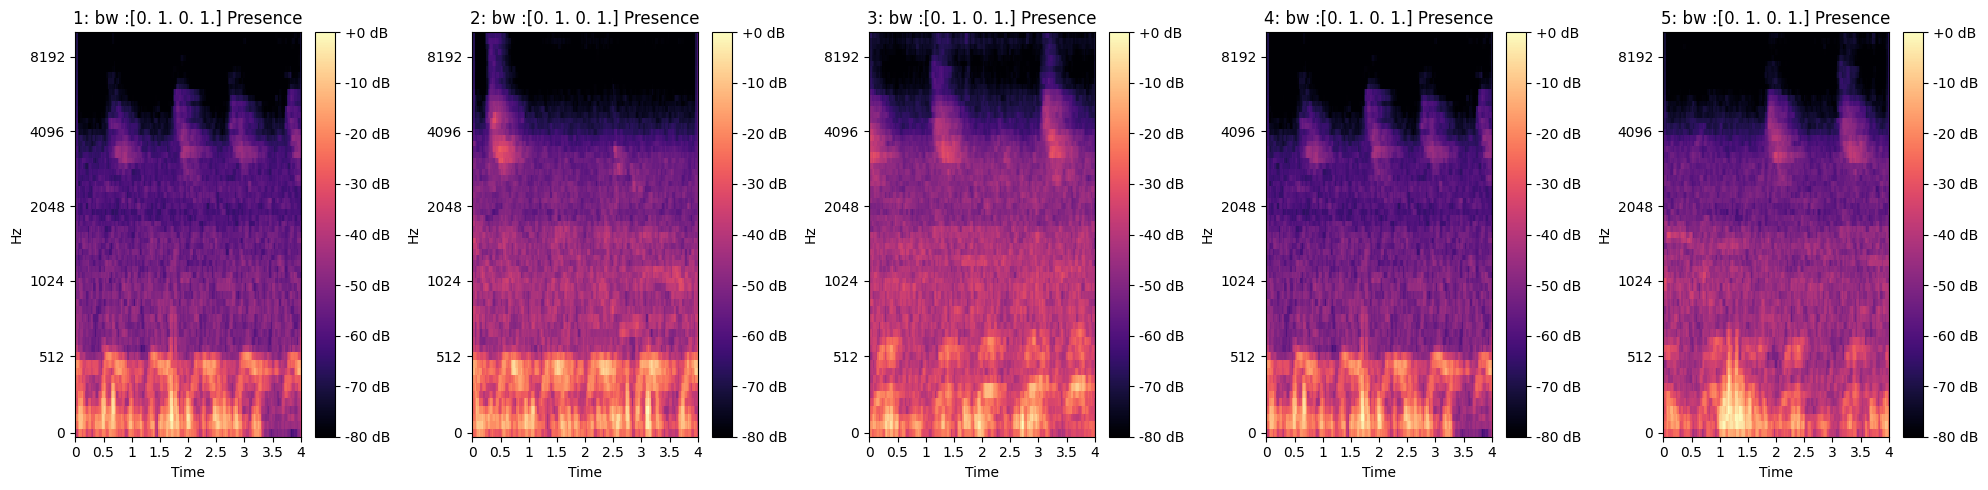

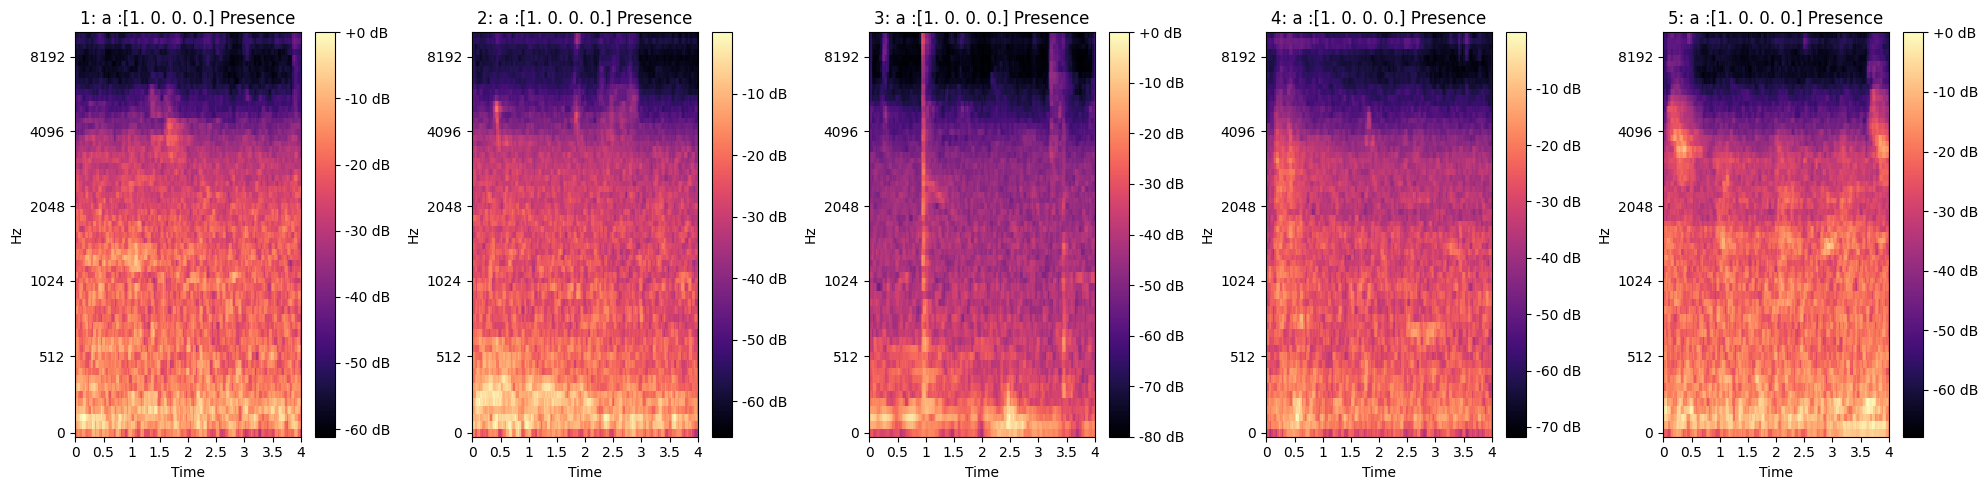

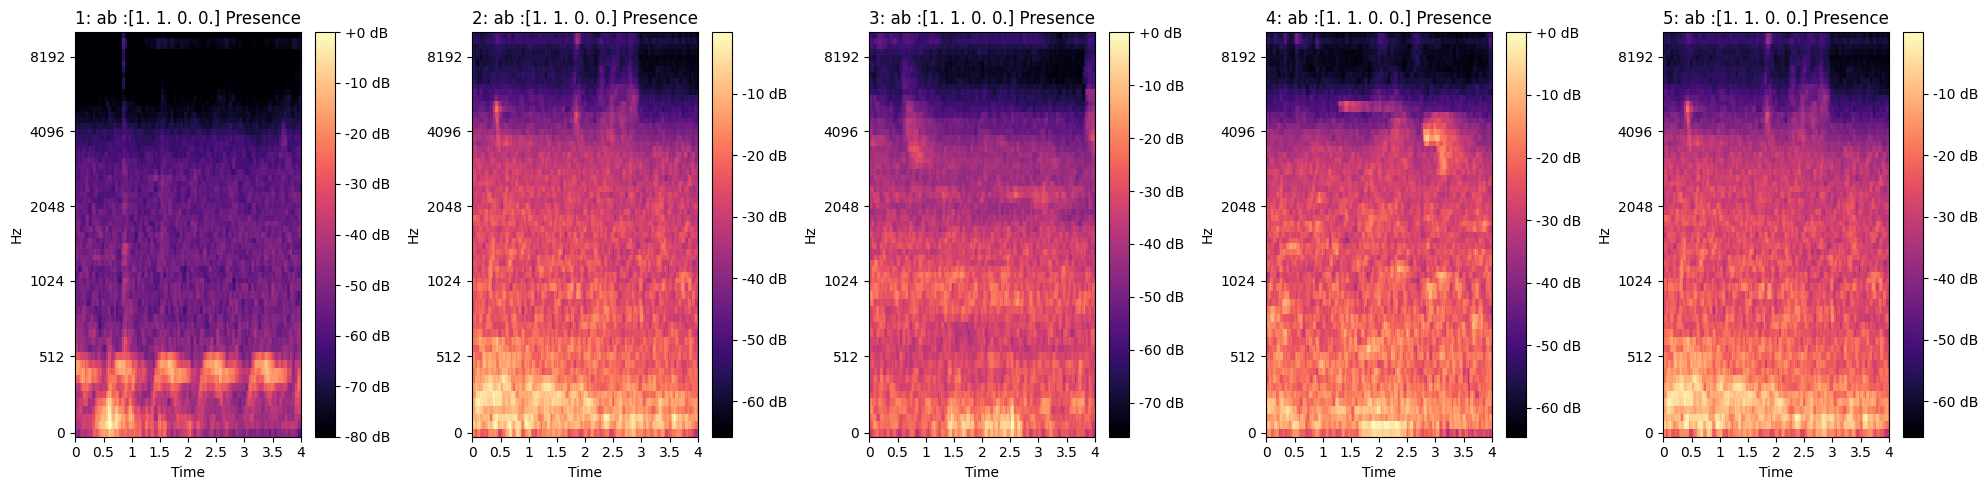

In [78]:
# Combination: [0. 0. 0. 1.],
# Combination: [0. 0. 1. 0.],
# Combination: [0. 1. 0. 0.],
# Combination: [0. 1. 0. 1.],
# Combination: [1. 0. 0. 0.],
# Combination: [1. 0. 0. 1.],
# Combination: [1. 1. 0. 0.],

plot_spectrograms(spectrograms= X_augmented, labels = Y_train, sr= downsample_rate, no_of_plots=5)

# Normalize the Spectrograms

In [79]:
# Min-max Normalization
def normalize_spectrograms(spectrograms):
  normalized_spectrograms =[]
  for spectrogram in spectrograms:
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    normalized_spectrograms.append(normalized_spectrogram)

  return np.asarray(normalized_spectrograms)


In [80]:
X_augmented = normalize_spectrograms(X_augmented)
X_val = normalize_spectrograms(X_val)

# Add dimension to match the  Tensorflow depth requirement

In [81]:
def add_extra_dim(spectrograms):
    '''
    Add an extra dimension to the data so that it matches
    the input requirement of Tensorflow.
    '''
    spectrograms = np.reshape(spectrograms,
                              (spectrograms.shape[0],
                                spectrograms.shape[1],
                                spectrograms.shape[2],1))
    return spectrograms

In [82]:
X_augmented = add_extra_dim(X_augmented)
X_val = add_extra_dim(X_val)
print(f'X_augmented shape  == {X_augmented.shape}')
print(f'X_val shape  == {X_val.shape}')

X_augmented shape  == (1278, 64, 157, 1)
X_val shape  == (51, 64, 157, 1)


# Train a neural network from randomly initialised weights

In [85]:
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense
from keras.models import Model

inputs = Input(shape=(64,157,1))

x = inputs

x = Conv2D(filters = 32,kernel_size=4, activation='relu', input_shape=(64,157,1))(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 64,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 128,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
# x = Flatten()(x)
# x = Dense(4, activation='sigmoid')(x)

outputs = x

model_2 = Model(inputs, outputs)

print(model_2.summary());

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 157, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 61, 154, 32)         │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 27, 74, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 13, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 10, 34, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 5, 17, 128)          │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,576 (642.88 KB)

 Trainable params: 164,576 (642.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [86]:
# train a neural network from randomly initialised weights
from keras.layers import Conv2D, Input, MaxPooling2D, Flatten, Dense, Reshape, ConvLSTM2D
from keras.models import Model

inputs = Input(shape=(64,157,1))

x = inputs

x = Conv2D(filters = 32,kernel_size=4, activation='relu', input_shape=(64,157,1))(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 64,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Conv2D(filters = 128,kernel_size=4, activation='relu')(x)
x = MaxPooling2D(2)(x)
x = Reshape((5, 17, 128,1))(x)
x = ConvLSTM2D(16, activation="relu",kernel_size=4,return_sequences=True)(x)
x = ConvLSTM2D(32, activation="relu",kernel_size=4)(x)
x = Flatten()(x)
x = Dense(4, activation='sigmoid')(x)

outputs = x

model_2 = Model(inputs, outputs)

print(model_2.summary());

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 157, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 61, 154, 32)         │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 30, 77, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 27, 74, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 13, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 10, 34, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 5, 17, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 5, 17, 128, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)           │ (None, 5, 14, 125, 16)      │          17,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)           │ (None, 11, 122, 32)         │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 42944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │         171,780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,260 (1.73 MB)

 Trainable params: 452,260 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

None


In [87]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history_2 = model_2.fit(X_augmented,
          Y_augmented,
          epochs=20,
          batch_size=32,
          validation_data=(X_val, Y_val))

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 328s 8s/step - accuracy: 0.3257 - loss: 0.6292 - val_accuracy: 0.5686 - val_loss: 0.5234
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 368s 8s/step - accuracy: 0.3386 - loss: 0.5483 - val_accuracy: 0.4902 - val_loss: 0.4515
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 319s 8s/step - accuracy: 0.4636 - loss: 0.4800 - val_accuracy: 0.3529 - val_loss: 0.4685
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 326s 8s/step - accuracy: 0.4289 - loss: 0.4818 - val_accuracy: 0.5294 - val_loss: 0.4322
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 307s 8s/step - accuracy: 0.3916 - loss: 0.4736 - val_accuracy: 0.4902 - val_loss: 0.4235
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 320s 8s/step - accuracy: 0.4291 - loss: 0.4794 - val_accuracy: 0.4510 - val_loss: 0.4272
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 321s 8s/step - accuracy: 0.4458 - loss: 0.4754 - val_accuracy: 0.6078 - val_loss: 0.3888
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 323s 8s/step - accuracy: 0.4773 - loss: 0.4639 - val_accuracy: 0.5882 - v

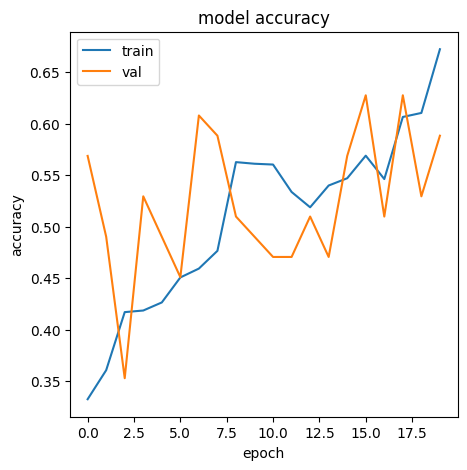

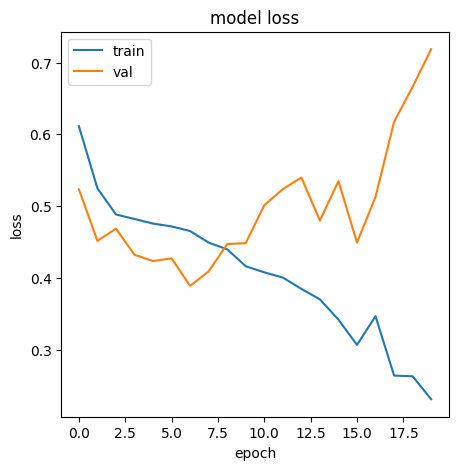

In [88]:
plt.figure(figsize=(5, 5))
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# Save plot
plt.savefig(f"/content/drive/MyDrive/model_2_accuracy.pdf", format="pdf", dpi=3000)
plt.show()

# summarize history for loss
plt.figure(figsize=(5, 5))
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f"/content/drive/MyDrive/model_2_loss.pdf", format="pdf", dpi=3000)
plt.show()

In [89]:
# Save the model weights to your disk once you have your best model
model_2.save_weights('/content/drive/MyDrive/best_model_2_weights.weights.h5')
print("Model weights saved to disk.")


Model weights saved to disk.


In [90]:
# Write a function that takes in timestamps and groups the predicted
# events together. For example, if your model things that seconds
# 0,1,2,3 are all events of type [0,0,1,1] then group them togeter

def group_predicted_events(timestamps, predictions):
  grouped_events = []
  current_event = {
      'event' : None,
      'start' : None,
      'end' : None
  }

  for i, (timestamp, prediction) in enumerate(zip(timestamps, predictions)):
    prediction = list(prediction)
    #print(f'prediction\n{prediction}')
    if current_event['event'] is None:
      # Create a new group
      current_event['event'] = prediction
      current_event['start'] = timestamp
      current_event['end'] = timestamp
      #print(f'current_event {current_event}')
    elif prediction == current_event['event']:
      #print(f'prediction = {prediction}\ncurrent_event={current_event["event"]}\ntimestamp ={timestamp}')
      # update the end timestamp of the current event
      current_event['end'] = timestamp
    else:
      # append the current event to grouped_events and start the next event
      grouped_events.append(current_event)
      #print('starting a new event')
      current_event = {
          'event': prediction,
          'start': timestamp,
          'end': timestamp
      }

  if current_event['event'] is not None:
    #print('adding the last event')
    grouped_events.append(current_event)

  return grouped_events



In [91]:
# write a function that takes your model and predicts on a single test file
# use this function signature:  def predict_single_file(test_file_name, test_path, model):
# this function should produce a plot, showing time on the x-axis, and it should
# inform the person viewing the plot as to what types of acoustic events occured
# during that time. The plot should be as informative as possible so someone
# will know what happened during this file

In [92]:
def convert_to_event_labels(predictions):
    predictions = np.asarray(predictions)
    binary_output = []
    max_val = np.max(predictions)

    if max_val < 5:
        if predictions.ndim == 1:
            # For 1D array
            binary_output = (predictions == predictions.max()).astype(int)
        else:
            # For 2D array
            binary_output = (predictions == predictions.max(axis=1, keepdims=True)).astype(int)
    else:
        for prediction in predictions:
            if prediction >= 5:
                binary_output.append(1)
            else:
                binary_output.append(0)

    return np.array(binary_output)

In [93]:
# Function to segment signal and create spectrograms
def create_spectrograms(signal, sample_rate, segment_duration, n_fft, hop_length, n_mels):
    segment_length = int(sample_rate * segment_duration)  # Number of samples per segment
    total_segments = len(signal) // segment_length  # Total number of complete segments
    spectrograms = []

    for i in range(total_segments):
        # Extract segment
        start = i * segment_length
        end = start + segment_length
        segment = signal[start:end]

        # Create spectrogram
        s = librosa.feature.melspectrogram(y=segment, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        s_db = librosa.power_to_db(s, ref=np.max)
        spectrograms.append(s_db)

    return np.asarray(spectrograms)

In [94]:
# Min-max Normalization
def normalize_spectrogram(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)
    normalized_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    return normalized_spectrogram


In [95]:
def predict_spectrograms(model, spectrograms):
    predictions = []

    for spectrogram in spectrograms:
        # Normalize the spectrogram
        spectrogram_normalized = normalize_spectrogram(spectrogram)

        # Expand dimensions to match the model's input shape
        spectrogram_input = np.expand_dims(np.expand_dims(spectrogram_normalized, axis=-1), axis=0)

        # Predict and append to the predictions list
        prediction = model.predict(spectrogram_input, verbose=0)
        predictions.append(prediction)

    # Convert predictions list to a NumPy array
    return np.vstack(predictions)


In [96]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_acoustic_events(event_dict,filename):
    # Map events to colors for visualization
    event_labels = {tuple([1, 0, 0, 0]): 'Anthrophony',
                    tuple([0, 1, 0, 0]): 'Biophony',
                    tuple([0, 0, 1, 0]): 'Nothing',
                    tuple([0, 0, 0, 1]): 'Wind',
                    tuple([1, 1, 0, 0]): 'Anthrophony|Biophony',
                    tuple([1, 1, 0, 1]): 'Anthrophony|Biophony|Wind',
                    tuple([1, 0, 0, 1]): 'Anthrophony|Wind',
                    tuple([0, 1, 0, 1]): 'Biophony|Wind',
                   }
    event_colors = {
        'Anthrophony': 'blue',
        'Biophony': 'orange',
        'Nothing': 'gray',
        'Wind': 'brown',
        'Anthrophony|Biophony': 'yellow',
        'Anthrophony|Biophony|Wind': 'green',
        'Anthrophony|Wind':'teal',
        'Biophony|Wind':'skyblue'
    }

    fig, ax = plt.subplots(figsize=(18, 6))

    # Add rectangles for each event
    for event in event_dict:
        label = event_labels.get(tuple(event['event']), 'Unknown')
        color = event_colors.get(label, 'gray')
        ax.add_patch(
            patches.Rectangle(
                (event['start'], 0),  # Start at (x=start, y=0)
                event['end'] - event['start'],  # Width (end - start)
                1,  # Height
                color=color,
                alpha=0.6,
                label=label if label not in [p.get_label() for p in ax.patches] else None
            )
        )

    # Configure plot
    ax.set_xlim(0, max(e['end'] for e in event_dict) + 2)
    ax.set_ylim(-1, 2)
    ax.set_yticks([])
    ax.set_xlabel('Time (seconds)')
    ax.set_title(f'{filename} Predicted Acoustic Events Over Time')

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))
    ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')
    plt.savefig(f"/content/drive/MyDrive/{filename}_predicted_plot_1.pdf", format="pdf", dpi=3000)
    plt.show()

In [97]:
def predict_single_file(test_file_name, test_path, model):
    downsample_rate = 20000
    segment_duration = 2


    # Spectrogram hyper-parameters
    # -----------------------------
    n_fft = 1024
    hop_length = 256
    n_mels = 64

    # Read audio file
    signal, original_sample_rate = read_audio_file(test_file_name)

    # Resample signal
    signal_downsampled = librosa.resample(y=signal, orig_sr=original_sample_rate, target_sr=downsample_rate)

    # Create Spectrograms
    spectrograms = create_spectrograms(signal_downsampled,downsample_rate, segment_duration,n_fft, hop_length, n_mels)

    # Normalize spectrograms and make predictions
    predictions = predict_spectrograms(model, spectrograms)

    # Convert to event labels
    event_labels = []
    for prediction in predictions:
      event_labels.append(convert_to_event_labels(prediction))

    event_labels = np.asarray(event_labels)

    # Create timestamps
    timestamps = np.arange(segment_duration,len(event_labels)+segment_duration,segment_duration)

    # Group events
    grouped_events = group_predicted_events(timestamps, event_labels)

    # Visualize grouped events
    plot_acoustic_events(grouped_events,test_file_name)



In [98]:
model_2.load_weights('/content/drive/MyDrive/best_model_2_weights.weights.h5')
print("Model weights loaded successfully.")

Model weights loaded successfully.


In [110]:
# do not modify
test3 = '1APBxL5lyAX_cV0U5BLkz3BSrhUKm7zaB'
test4 = '1ROfjh47uZtnK-HVNiwcbAECC6HIwYtmk'
test5 = '144H3yHYIxHH6v_JY_-EP2--X5U7PxwbX'
test6 = '1I_GeHEt0EdoAptUjh9obDOoXXNUm1Rwq'
test7 = '1AdLXsvvbgSPSI6IrvDY0cSDIpccbtx4B'
test8 = '1nKdVkDEV4v8RTONoPQR0xiepc6B6_JSi'
test9 = '13k_o2W62I9aQRWmubT-U5-lQcRm4w6oi'
test10 = '1z-60L-piAo96URDKpfY7jW3V0UWiHfAt'

In [111]:
# This will download the training audio/annotations.
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [101]:
# do not modify
downloaded = drive.CreateFile({'id':test3})
downloaded.GetContentFile('20241113_102700_AIMS.WAV')

downloaded = drive.CreateFile({'id':test4})
downloaded.GetContentFile('20241113_092100_AIMS.WAV')

downloaded = drive.CreateFile({'id':test5})
downloaded.GetContentFile('20241113_022700_CC.WAV')

downloaded = drive.CreateFile({'id':test6})
downloaded.GetContentFile('20241112_061800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test7})
downloaded.GetContentFile('20241112_035100.WAV')

downloaded = drive.CreateFile({'id':test8})
downloaded.GetContentFile('20241112_024800.WAV')

downloaded = drive.CreateFile({'id':test9})
downloaded.GetContentFile('20241112_024800_AIMS.WAV')

downloaded = drive.CreateFile({'id':test10})
downloaded.GetContentFile('20241111_224500.WAV')

Predict on these files. You will be assessed on how well your model performs on these files and how informative your plot was at telling a story about what sounds happened in this file.

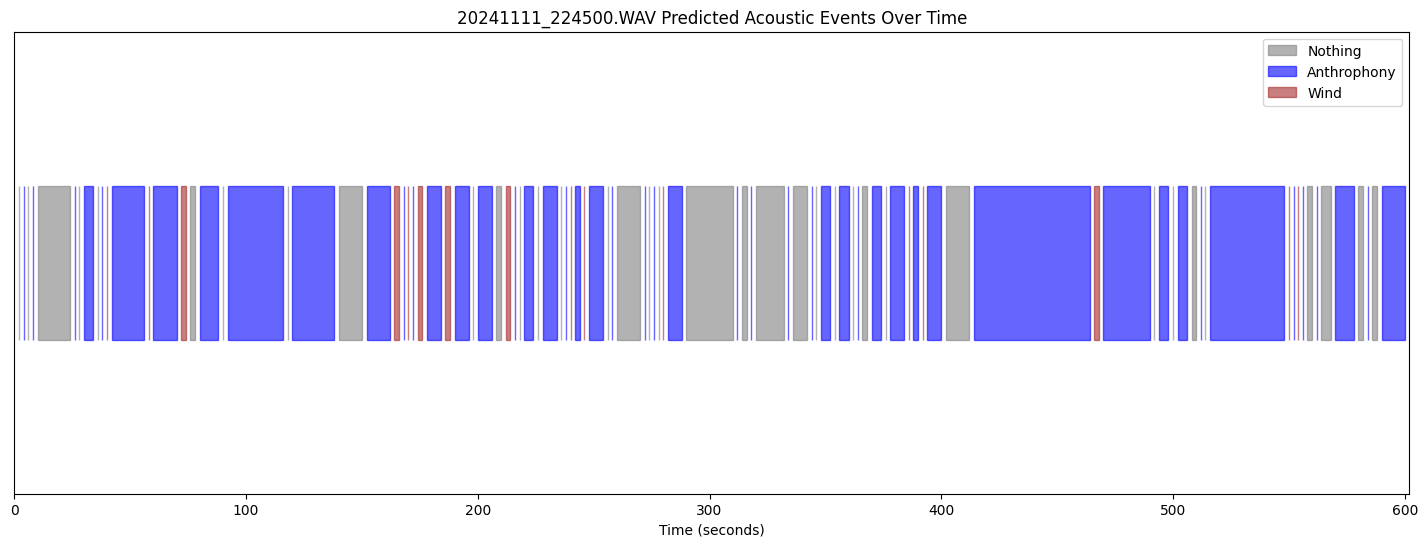

In [112]:
# do not modify
test_path = '.'
test_file_name = '20241111_224500.WAV'

predict_single_file(test_file_name, test_path, model_2)

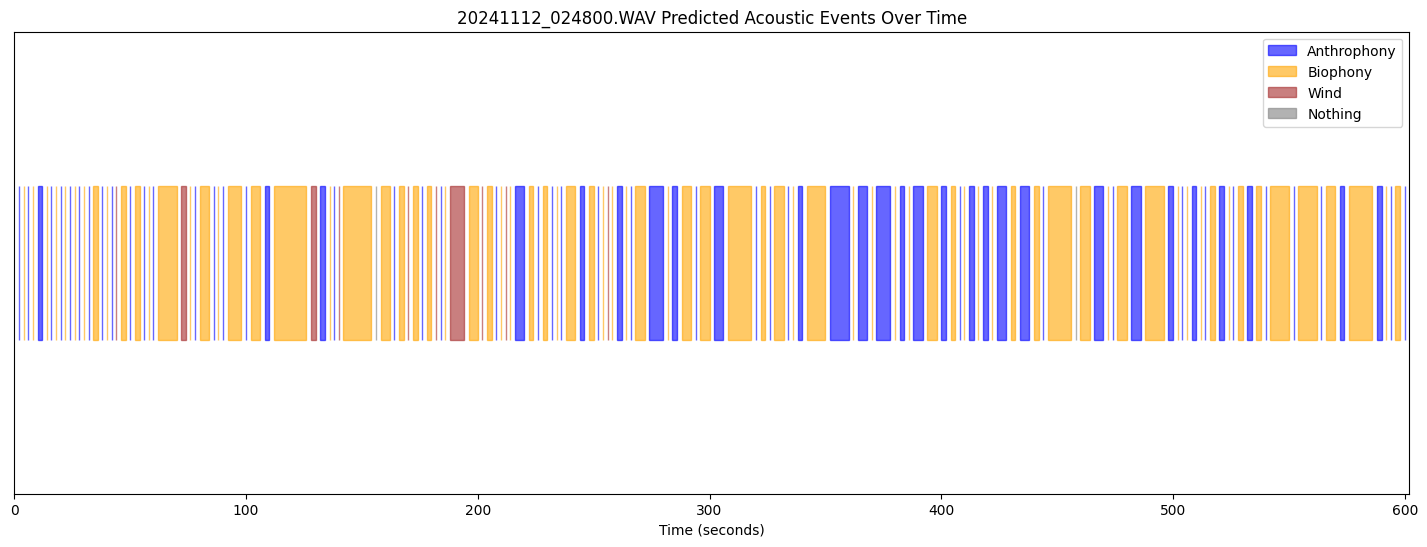

In [103]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800.WAV'

predict_single_file(test_file_name, test_path, model_2)

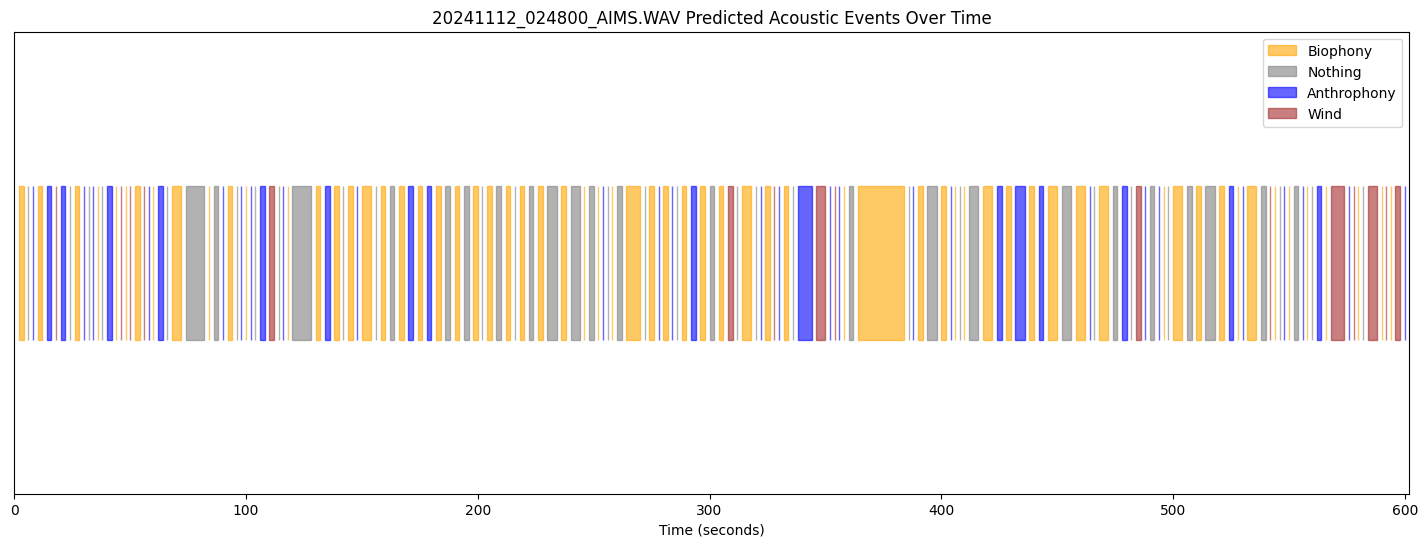

In [104]:
# do not modify
test_path = '.'
test_file_name = '20241112_024800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_2)

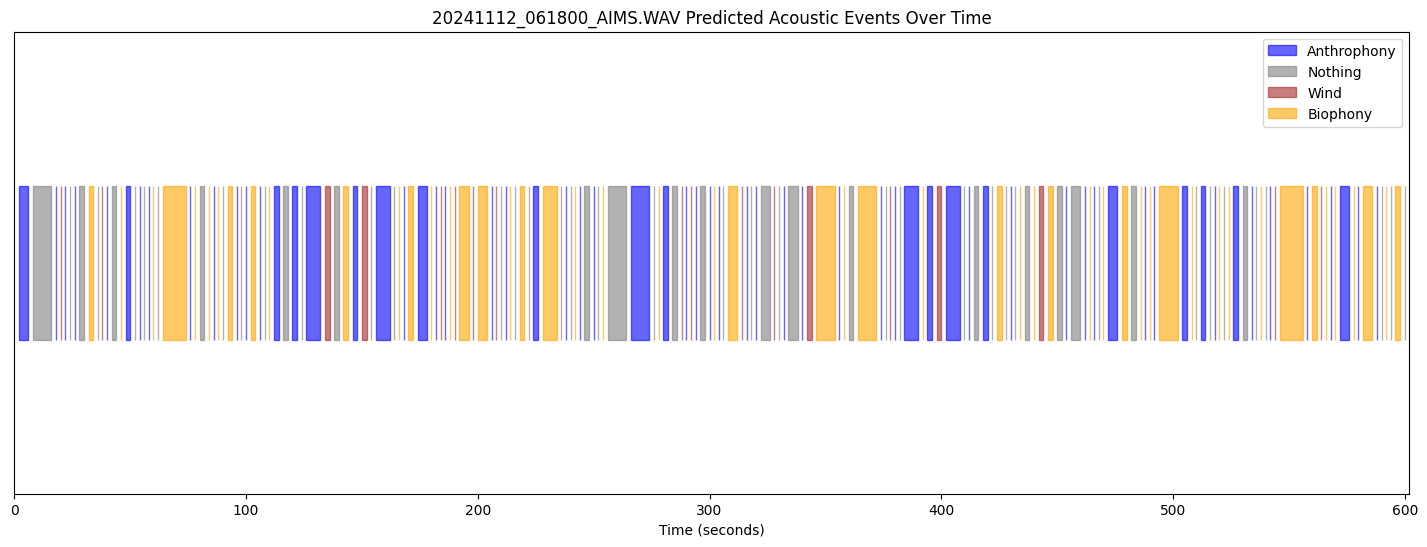

In [105]:
# do not modify
test_path = '.'
test_file_name = '20241112_061800_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_2)

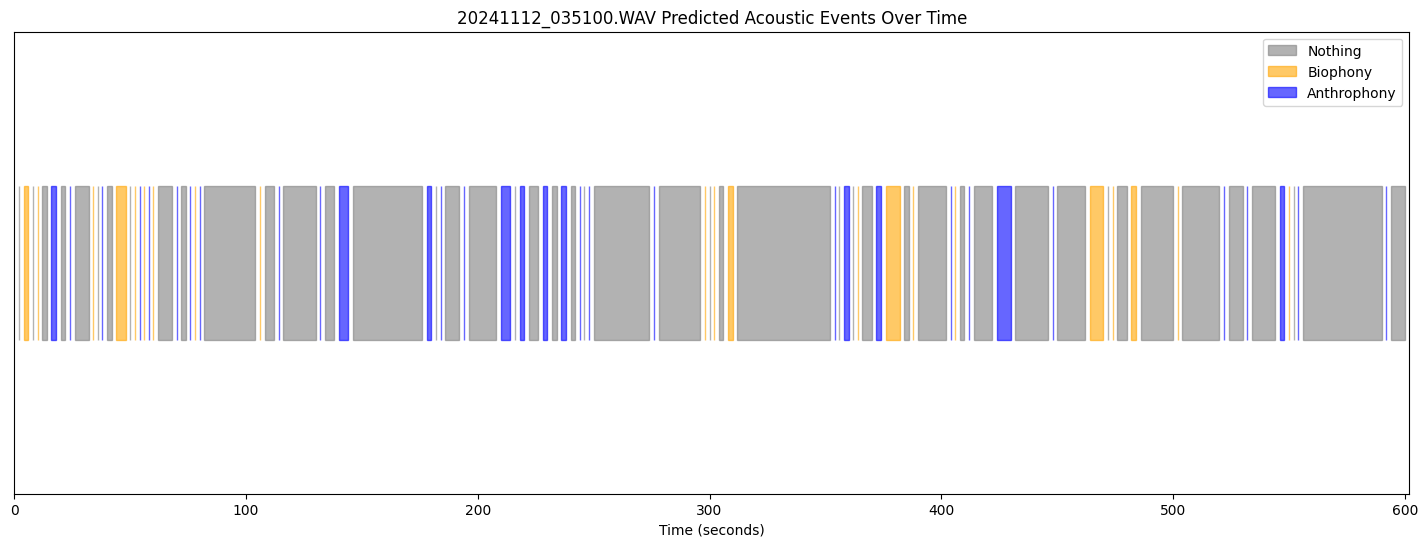

In [106]:
# do not modify
test_path = '.'
test_file_name = '20241112_035100.WAV'

predict_single_file(test_file_name, test_path, model_2)

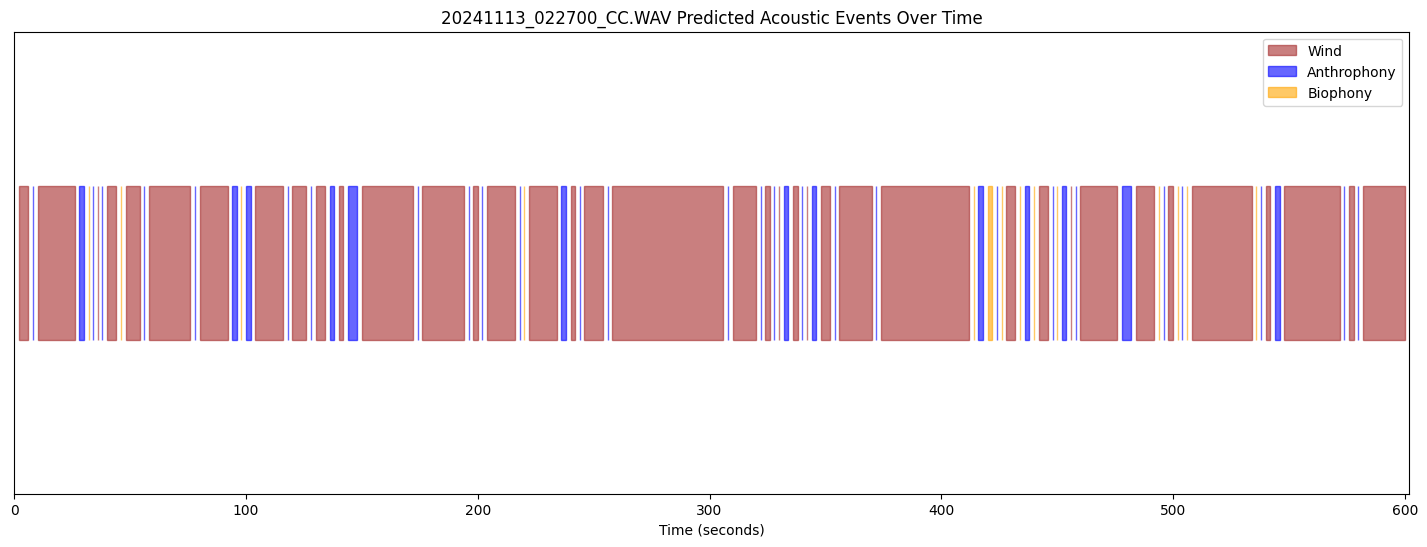

In [107]:
# do not modify
test_path = '.'
test_file_name = '20241113_022700_CC.WAV'

predict_single_file(test_file_name, test_path, model_2)

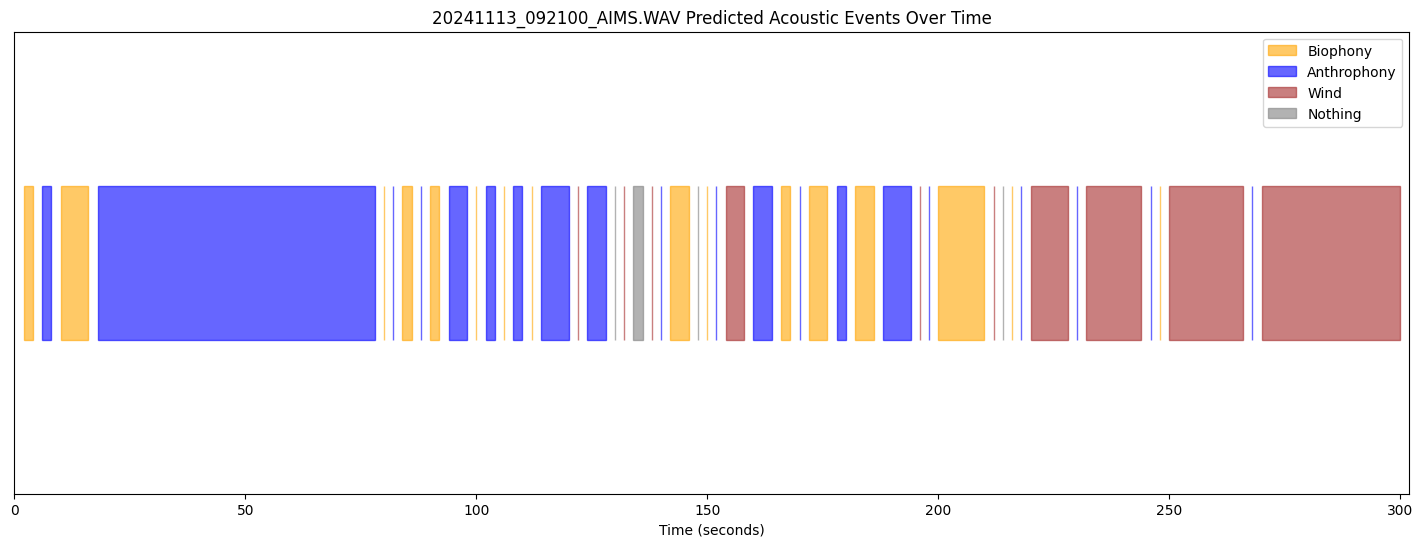

In [108]:
# do not modify
test_path = '.'
test_file_name = '20241113_092100_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_2)

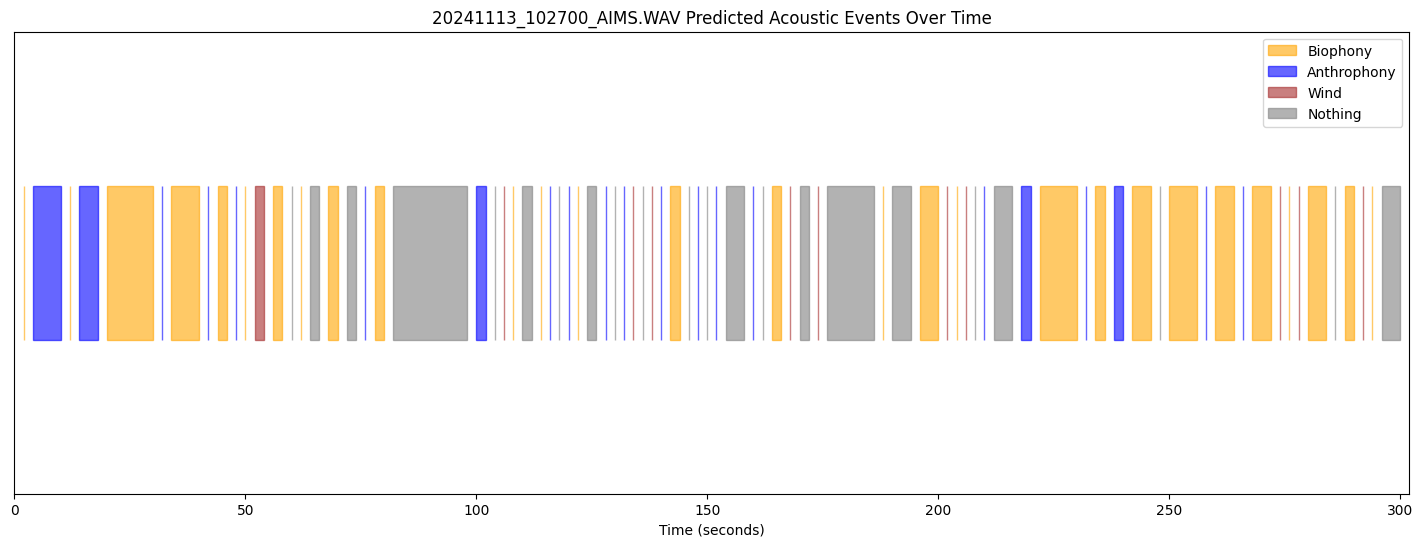

In [109]:
# do not modify
test_path = '.'
test_file_name = '20241113_102700_AIMS.WAV'

predict_single_file(test_file_name, test_path, model_2)